In [1]:
from plotter import *

Results 1 Thread

Reading Retr-Reorder-Gen-1Thread-Pipeline


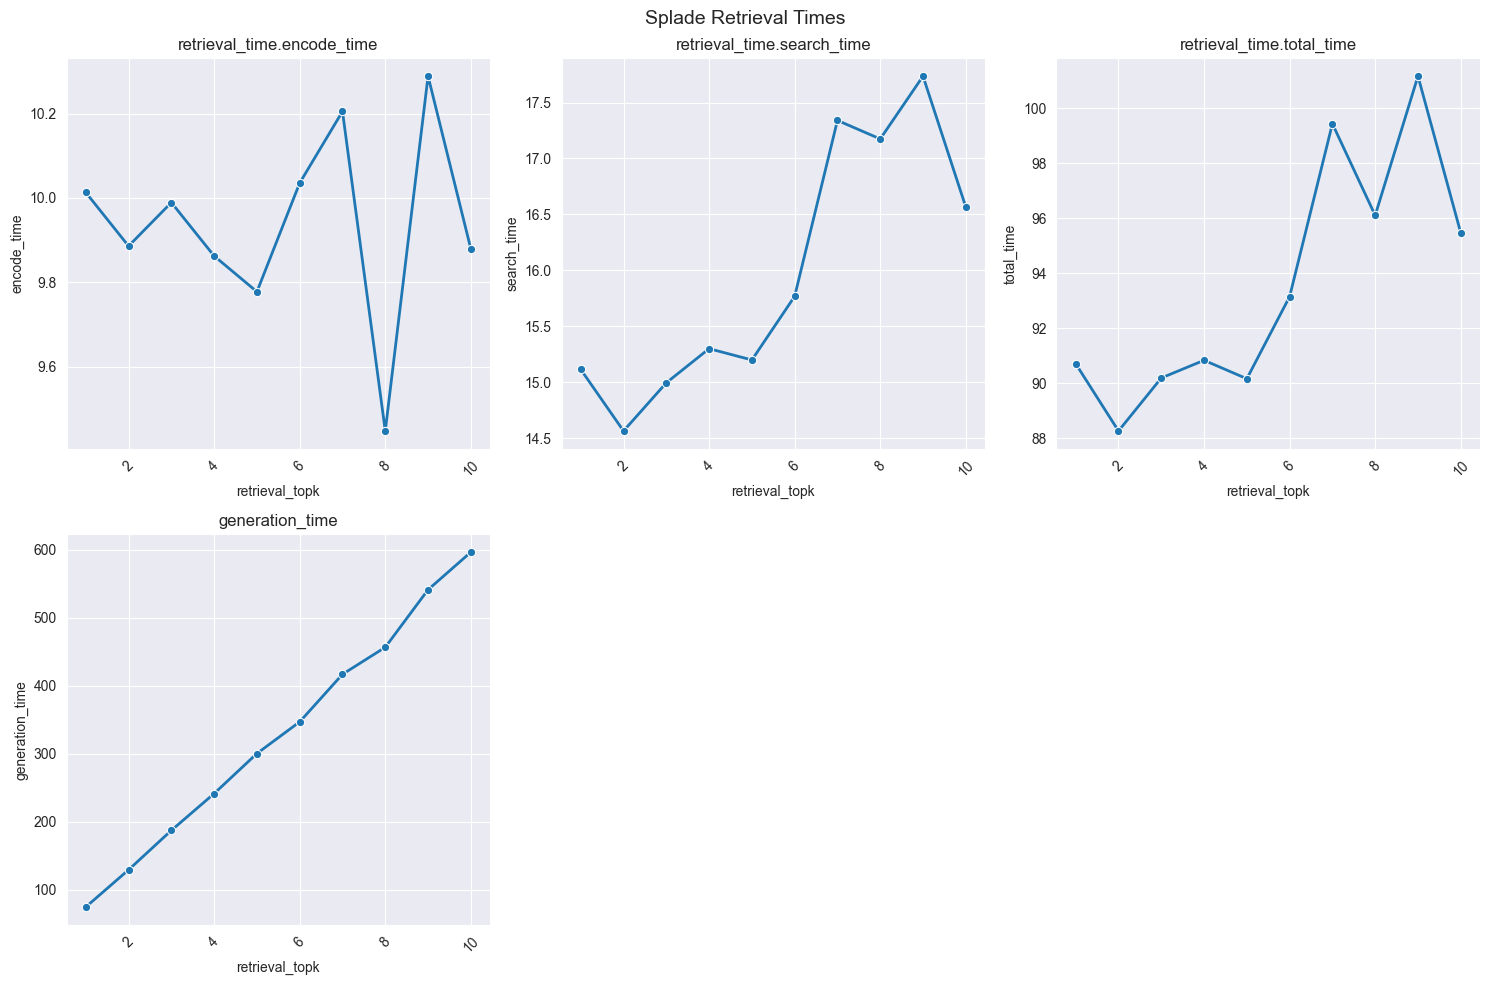

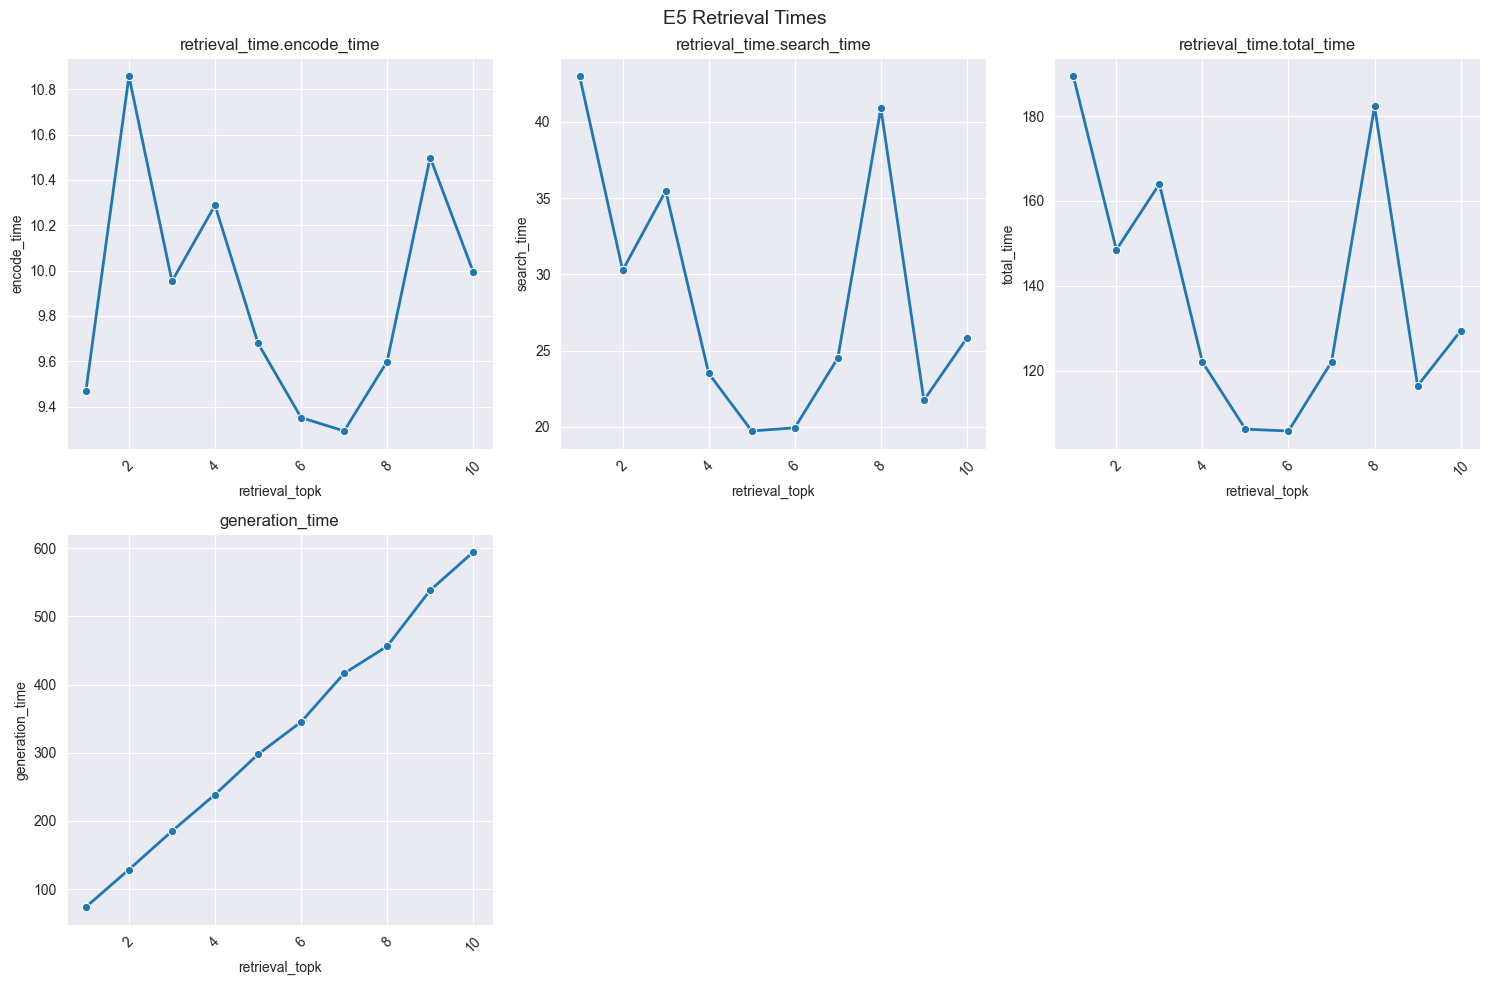

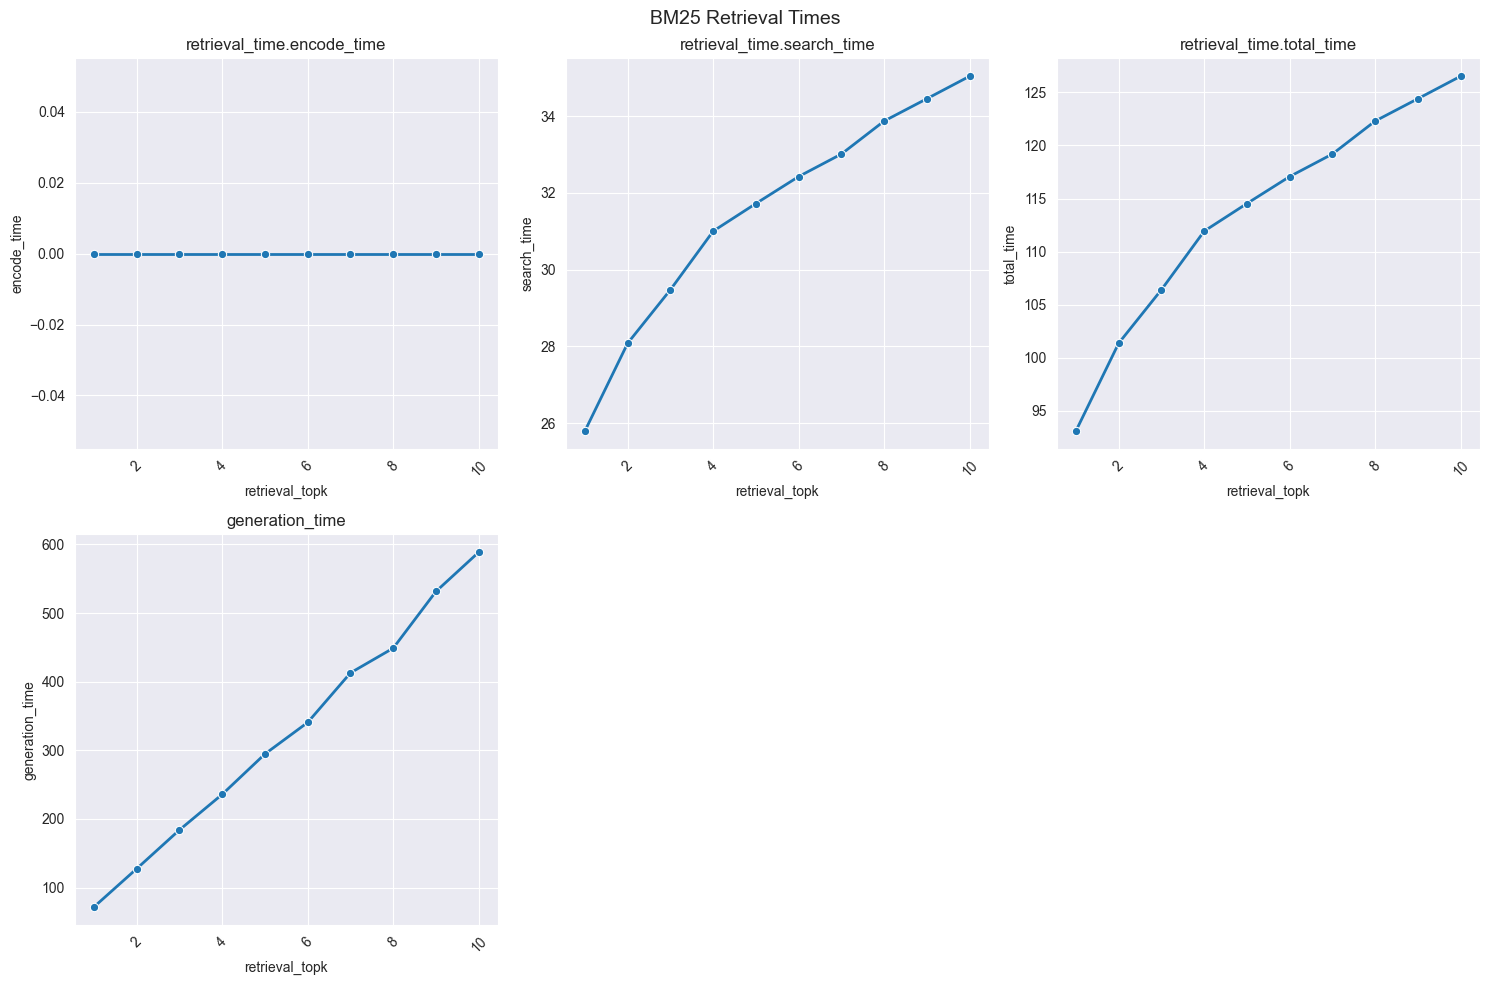

In [13]:
data = read_all_python_dicts_from_dir('results_time_1')

for item in data:
    encode = get_nested_value(item, "retrieval_time.encode_time") or 0
    search = get_nested_value(item, "retrieval_time.search_time") or 0
    item["retrieval_time"]['encode_time'] = (encode / 3610) * 1000
    item["retrieval_time"]['search_time'] = (search / 3610) * 1000
    item["retrieval_time"]["total_time"] = encode + search
    
    
splade = where(data, retrieval_method='splade')
plot_line(splade, [
    'retrieval_time.encode_time',
    'retrieval_time.search_time',
    'retrieval_time.total_time',
    'generation_time'
], 'retrieval_topk', title='Splade Retrieval Times')

e5 = where(data, retrieval_method='e5')
plot_line(e5, [
    'retrieval_time.encode_time',
    'retrieval_time.search_time',
    'retrieval_time.total_time',
    'generation_time'
], 'retrieval_topk', title='E5 Retrieval Times')


bm25 = where(data, retrieval_method='bm25')
plot_line(bm25, [
    'retrieval_time.encode_time',
    'retrieval_time.search_time',
    'retrieval_time.total_time',
    'generation_time'
], 'retrieval_topk', title='BM25 Retrieval Times')

Time 120 Threads

Reading Retr-Reorder-Gen-Pipeline


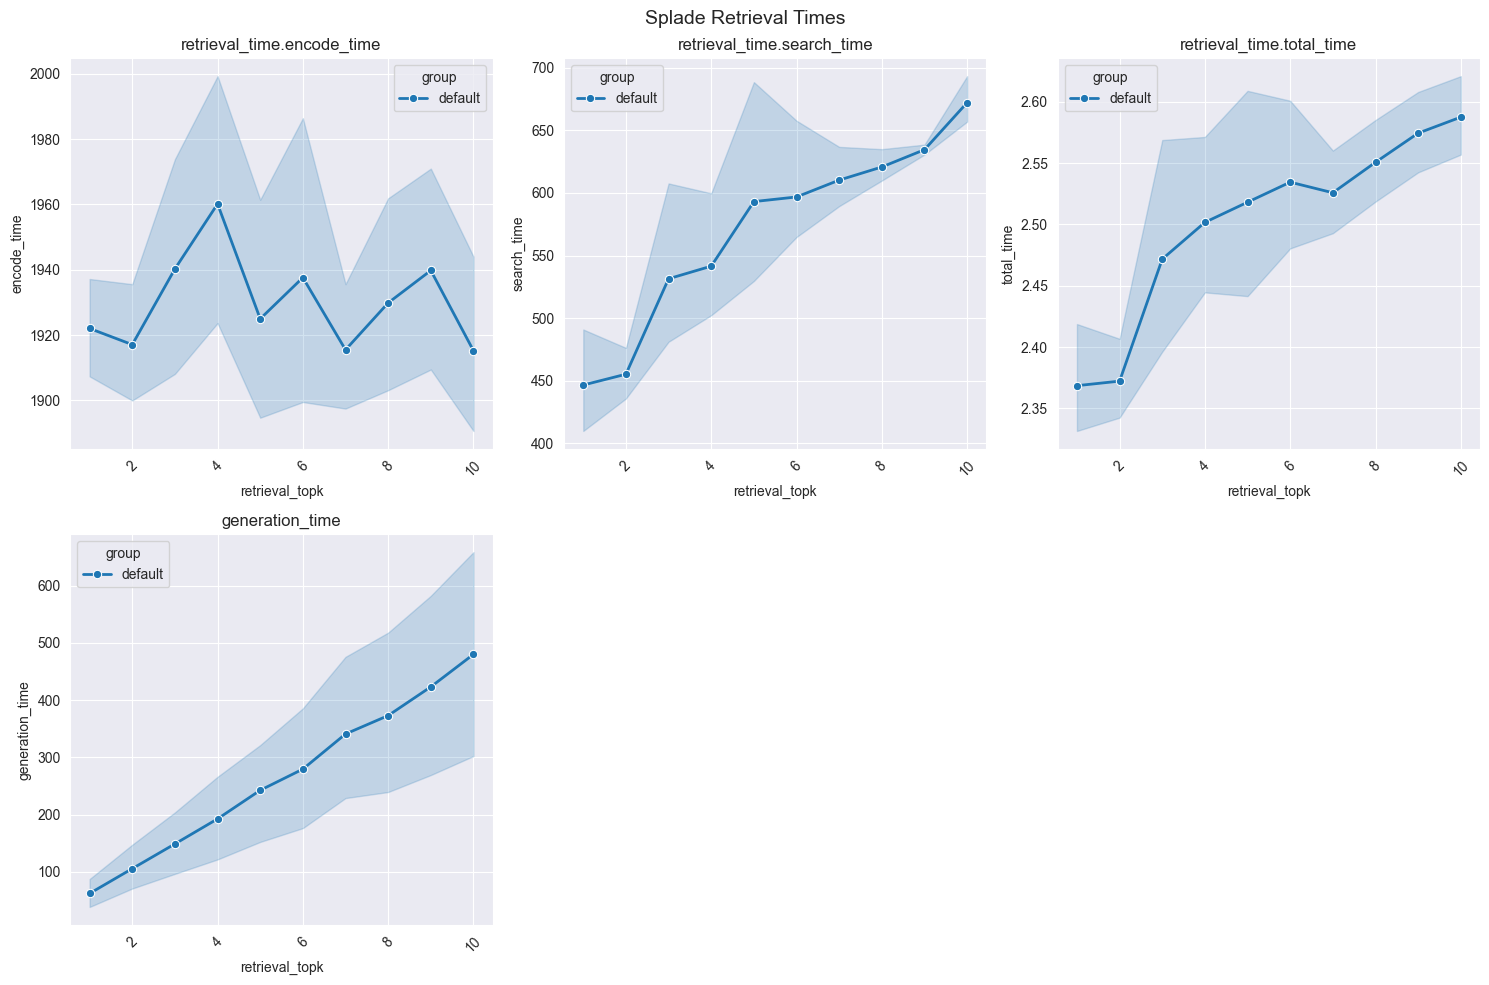

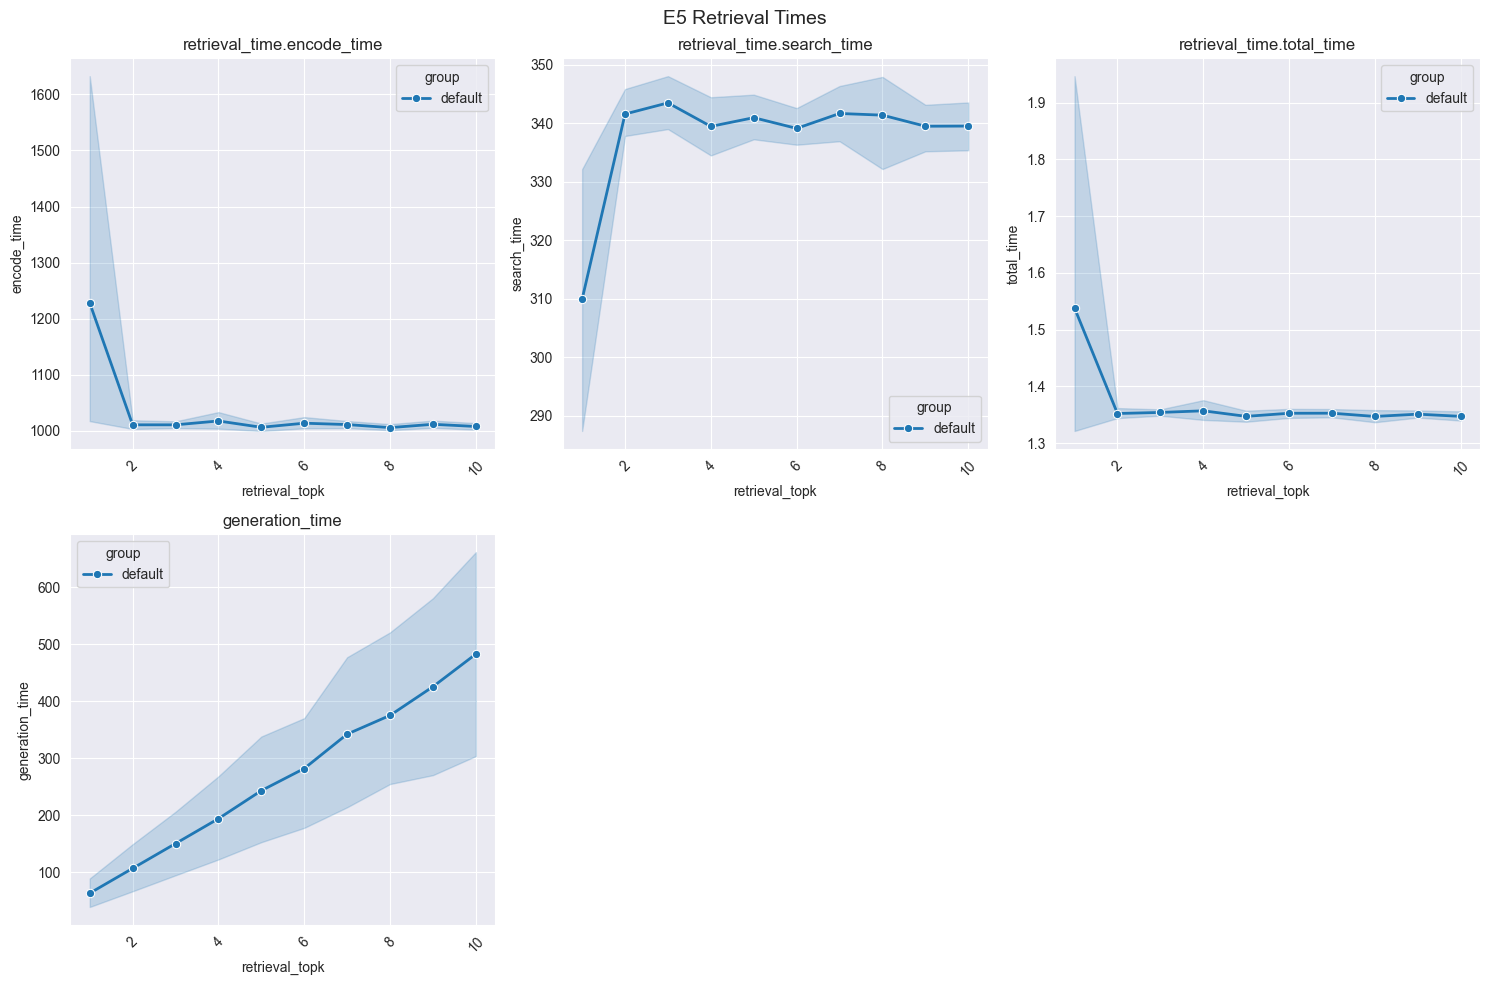

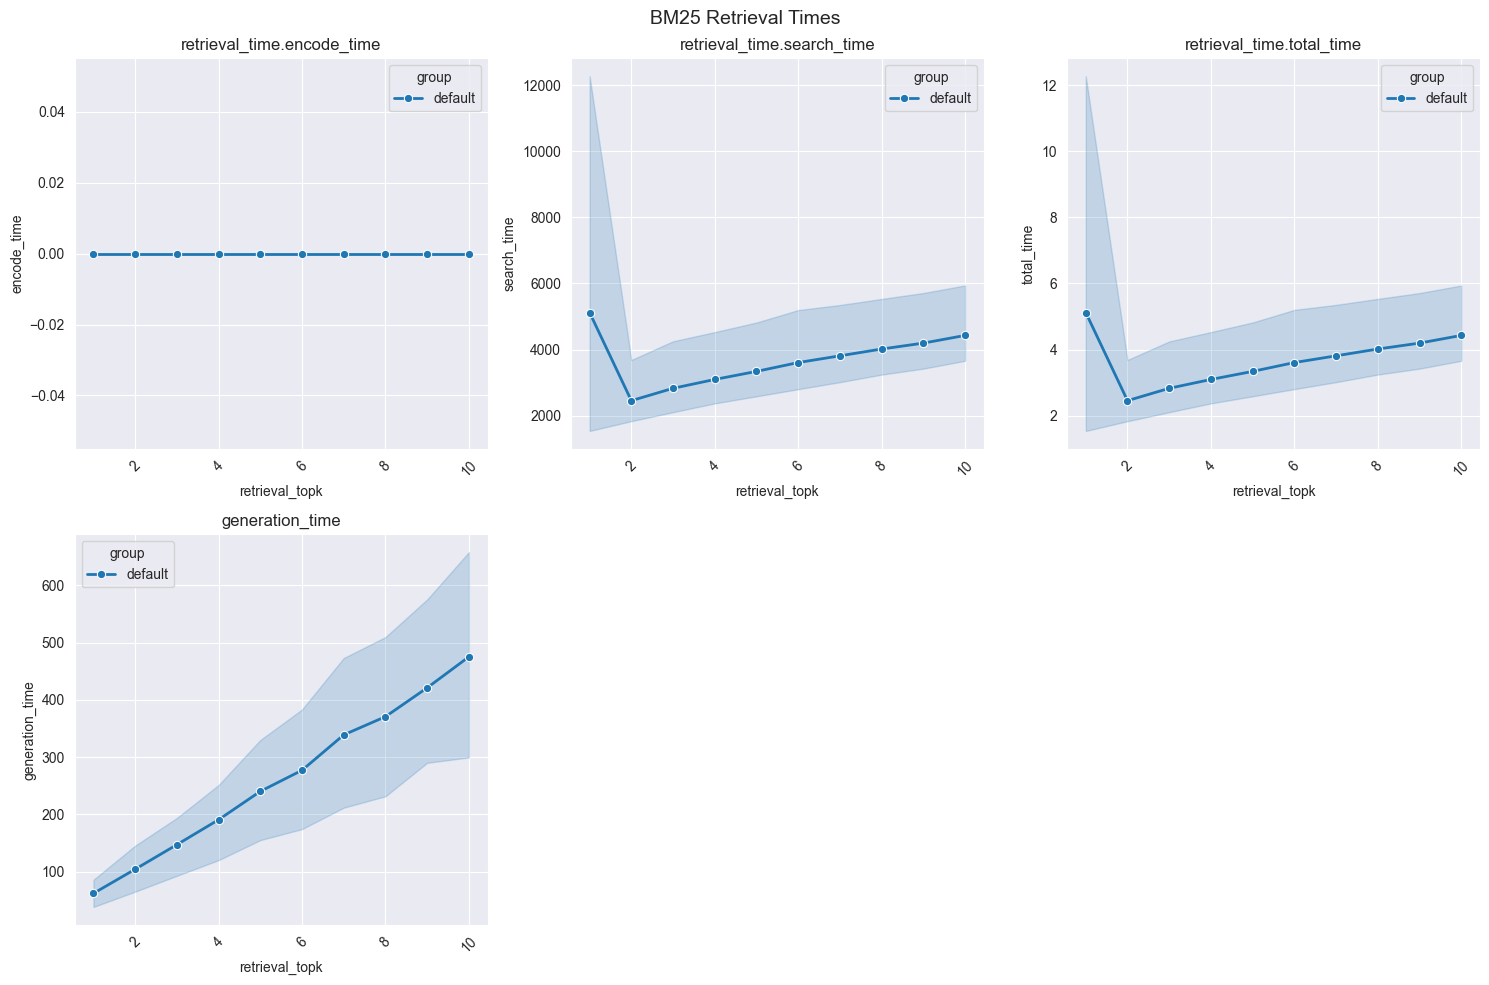

In [9]:
data = read_all_python_dicts_from_dir('results_std')

for item in data:
    encode = get_nested_value(item, "retrieval_time.encode_time") or 0
    search = get_nested_value(item, "retrieval_time.search_time") or 0
    item["retrieval_time"]['encode_time'] *= 1000
    item["retrieval_time"]['search_time'] *= 1000
    item["generation_time"] = item["generation_time"] / 3610 * 1000
    item["retrieval_time"]["total_time"] = encode + search
    
    
splade = where(data, retrieval_method='splade')
plot_line(splade, [
    'retrieval_time.encode_time',
    'retrieval_time.search_time',
    'retrieval_time.total_time',
    'generation_time'
], 'retrieval_topk', title='Splade Retrieval Times')

e5 = where(data, retrieval_method='e5')
plot_line(e5, [
    'retrieval_time.encode_time',
    'retrieval_time.search_time',
    'retrieval_time.total_time',
    'generation_time'
], 'retrieval_topk', title='E5 Retrieval Times')


bm25 = where(data, retrieval_method='bm25')
plot_line(bm25, [
    'retrieval_time.encode_time',
    'retrieval_time.search_time',
    'retrieval_time.total_time',
    'generation_time'
], 'retrieval_topk', title='BM25 Retrieval Times')

Retrieval Accuracy

In [3]:
# Total queries = 3610
data = read_all_python_dicts_from_dir('results_accuracy')

Reading Test-Pipeline


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def count_above_threshold(values, threshold):
    return sum(v >= threshold for v in values)

def enrich_rates(data, thresholds, total=3610):
    for item in data:
        for rate in thresholds:
            key = f"rates_{rate:.1f}"
            item[key] = count_above_threshold(item['tokens_rates'], rate) / total * 100

def make_heatmap_data(data, thresholds):
    matrix = {}
    topk_values = sorted(set(item['retrieval_topk'] for item in data))
    
    for rate in thresholds:
        row = []
        for topk in topk_values:
            matching_items = [item for item in data if item['retrieval_topk'] == topk]
            if not matching_items:
                row.append(0)
            else:
                values = [item.get(f"rates_{rate:.1f}", 0) for item in matching_items]
                avg = sum(values) / len(values)
                row.append(avg)
        matrix[rate] = row

    df = pd.DataFrame(matrix, index=topk_values).T
    df.index.name = "Answers tokens %"
    df.columns.name = "Number of retrieved documents"
    return df

def plot_rate_heatmap(data, thresholds):
    enrich_rates(data, thresholds)
    df_heatmap = make_heatmap_data(data, thresholds)
    
    plt.figure(figsize=(10,1.5))
    sns.heatmap(df_heatmap, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={"label": "% of queries"})
    plt.title("Answers tokens percentage in K documents retrieved")
    plt.tight_layout()
    plt.show()
    

def plot_threshold_line(data, threshold=1.0):
    methods = sorted(set(item['retrieval_method'] for item in data))
    topk_values = sorted(set(item['retrieval_topk'] for item in data))

    # Ensure enrichment of threshold rate
    enrich_rates(data, [threshold])

    # Prepare data for seaborn
    plot_data = []
    for method in methods:
        for topk in topk_values:
            matching_items = [
                item for item in data 
                if item['retrieval_method'] == method and item['retrieval_topk'] == topk
            ]
            if matching_items:
                avg_rate = sum(item.get(f"rates_{threshold:.1f}", 0) for item in matching_items) / len(matching_items)
                plot_data.append({
                    'Retrieval Method': method.upper(),
                    'Top-K': topk,
                    'Coverage %': avg_rate
                })

    df = pd.DataFrame(plot_data)

    # Plotting
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x='Top-K', y='Coverage %', hue='Retrieval Method', marker='o')
    plt.title(f'Coverage of Answer Tokens ≥ {threshold:.1f} Over Top-K Documents')
    plt.ylabel('% of Queries')
    plt.xlabel('Number of Retrieved Documents (Top-K)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


thresholds = list(reversed([round(0.1 * i, 1) for i in range(1, 11)]))  # [0.1, 0.2, ..., 1.0]

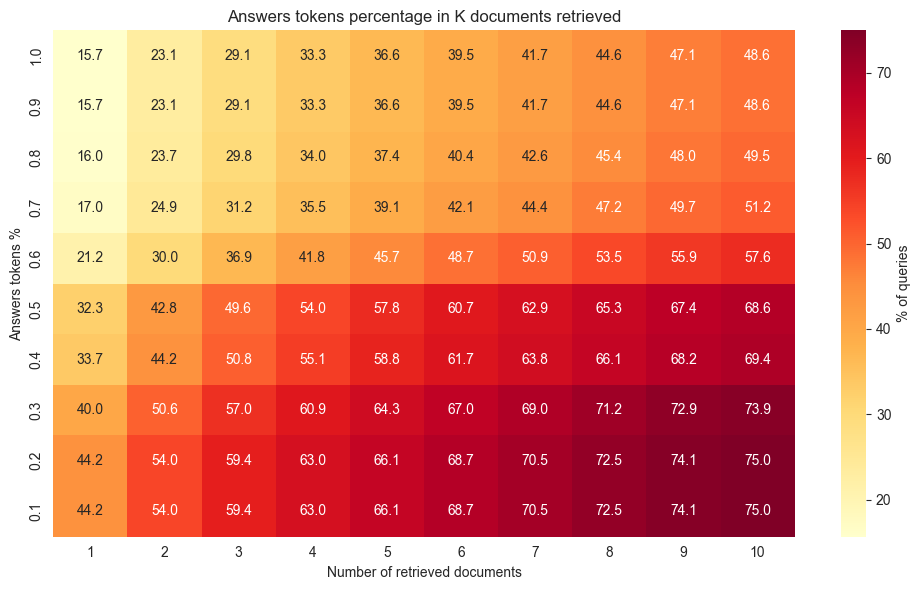

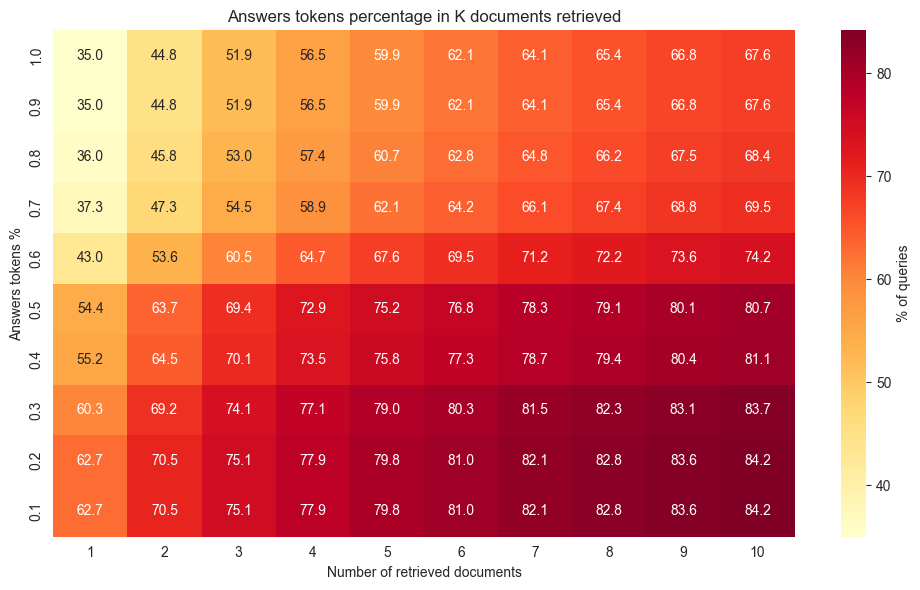

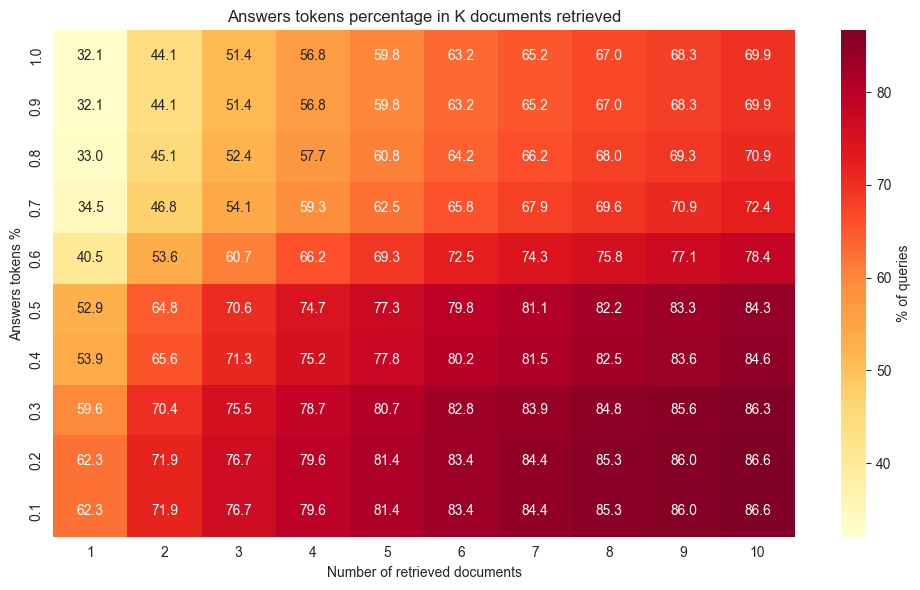

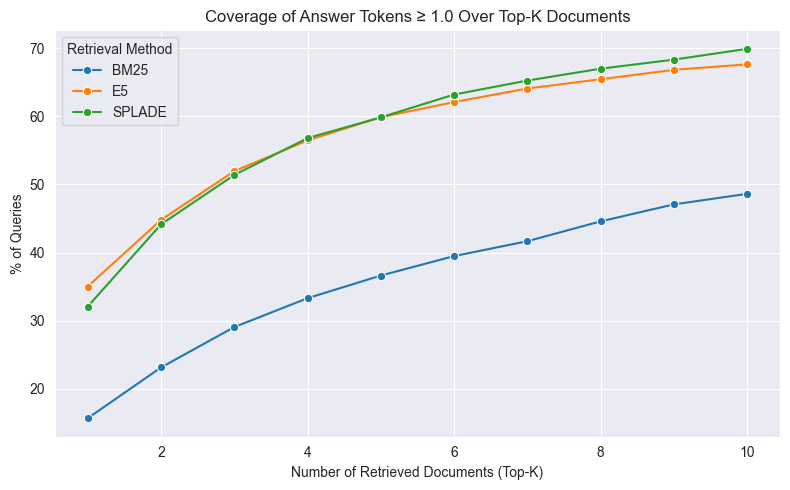

In [20]:

plot_rate_heatmap(where(data, retrieval_method='bm25'), thresholds)
plot_rate_heatmap(where(data, retrieval_method='e5'), thresholds)
plot_rate_heatmap(where(data, retrieval_method='splade'), thresholds)

plot_threshold_line(data, threshold=1.0)

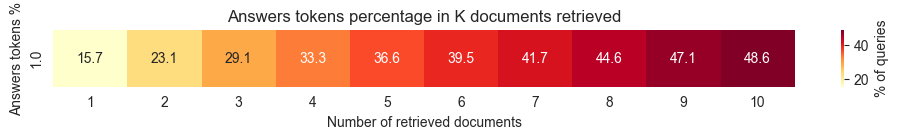

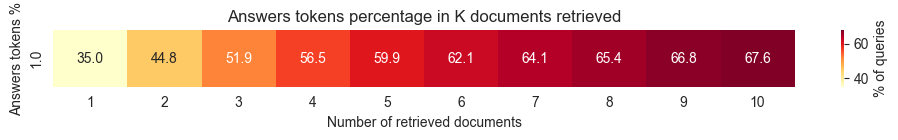

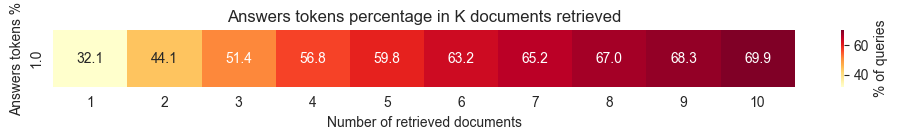

In [22]:

plot_rate_heatmap(where(data, retrieval_method='bm25'), [1.0])
plot_rate_heatmap(where(data, retrieval_method='e5'), [1.0])
plot_rate_heatmap(where(data, retrieval_method='splade'), [1.0])